In [ ]:
## LOCAL
%run __include.ipynb
## COLAB
# %run __setup_colab.ipynb

In [ ]:
from langfuse import Langfuse

langfuse = Langfuse()

In [119]:
import dspy

MODEL = "gemma3:1b-it-q4_K_M"

lm = dspy.LM(f"ollama/{MODEL}", cache=False, num_retries=20)
dspy.settings.configure(lm=lm, track_usage=False)

In [120]:
lm("Hello world!")

["Hi there! How's your day going?"]

In [ ]:
lm.inspect_history(1)

In [121]:
from sms_classifier import SMSClassifier

sms_classifier = SMSClassifier()

In [122]:
sms_classifier(
    sms_text="The Xmas story is peace.. The Xmas msg is love.. The Xmas miracle is jesus.. Hav a blessed month ahead &amp; wish U Merry Xmas..."
)

Prediction(
    category='ham'
)

In [77]:
lm.inspect_history(n=1)





[2025-04-01T06:18:19.163123]

System message:

Your input fields are:
1. `sms_text` (str)

Your output fields are:
1. `category` (Literal['ham', 'spam', 'smishing'])

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## sms_text ## ]]
{sms_text}

[[ ## category ## ]]
{category}        # note: the value you produce must exactly match (no extra characters) one of: ham; spam; smishing

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        Given an SMS text, predict whether it is ham, spam, or smishing.
        Output only the predicted label.


User message:

[[ ## sms_text ## ]]
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question

Respond with the corresponding output fields, starting with the field `[[ ## category ## ]]` (must be formatted as a valid Python Literal['ham', 'spam', 'smishing']), and then ending with the marker for `[[ ## completed #

In [92]:
dataset = langfuse.get_dataset("sms_phishing_test")
from dspy import Example

test_ds = []
for item in dataset.items:
    test_ds.append(
        Example(sms_text=item.input, category=item.expected_output).with_inputs(
            "sms_text"
        )
    )

In [165]:
from evaluation_helpers import plot_metrics, run_evaluation
from datetime import datetime

timestamp = int(datetime.now().timestamp())
models = ["gemma3:1b-it-q4_K_M", "gemma3:1b", "qwen2.5:14b", "gemma3:12b"]
# models = ["smollm2:360m", "smollm2:1.7b", "qwen2.5:0.5b", "qwen2.5:1.5b"]

# full run
# models = [
#         "smollm2:360m", "smollm2:1.7b",
#         "qwen2.5:0.5b", "qwen2.5:1.5b",
#         "gemma3:1b", "gemma3:4b", "granite3.2:2b",
#         "gemma3:12b", "qwen2.5:14b", "phi4:14b"
# ]

classes = ["ham", "spam", "smishing"]

run_evaluation(models, sms_classifier, test_ds, classes, timestamp, prefix="baseline")

Average Metric: 78.00 / 100 (78.0%): 100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


In [166]:
from evaluation_helpers import get_all_metric

metrics_baseline = get_all_metric(models, timestamp, classes, prefix="baseline")
metrics_baseline["gemma3:1b-finetune"] = metrics_baseline.pop("gemma3:1b-it-q4_K_M")
metrics_baseline

{'gemma3:1b': {'precision': 0.3250106700810926,
  'recall': 0.3317269076305221,
  'f1': 0.31040564373897706},
 'qwen2.5:14b': {'precision': 0.8266666666666667,
  'recall': 0.6971887550200804,
  'f1': 0.6415523804058836},
 'gemma3:12b': {'precision': 0.5404761904761904,
  'recall': 0.667536813922356,
  'f1': 0.575462962962963},
 'gemma3:1b-finetune': {'precision': 0.8771929824561404,
  'recall': 0.721285140562249,
  'f1': 0.6963739912483233}}

In [167]:
timestamp_ape = "1743493037"

In [168]:
ape_metrics = get_all_metric(["gemma3:1b"], timestamp_ape, classes, prefix="ape")
ape_metrics = {"gemma3:1b-ape": ape_metrics["gemma3:1b"]}
ape_metrics

{'gemma3:1b-ape': {'precision': 0.5333333333333333,
  'recall': 0.6546184738955824,
  'f1': 0.5771983640081799}}

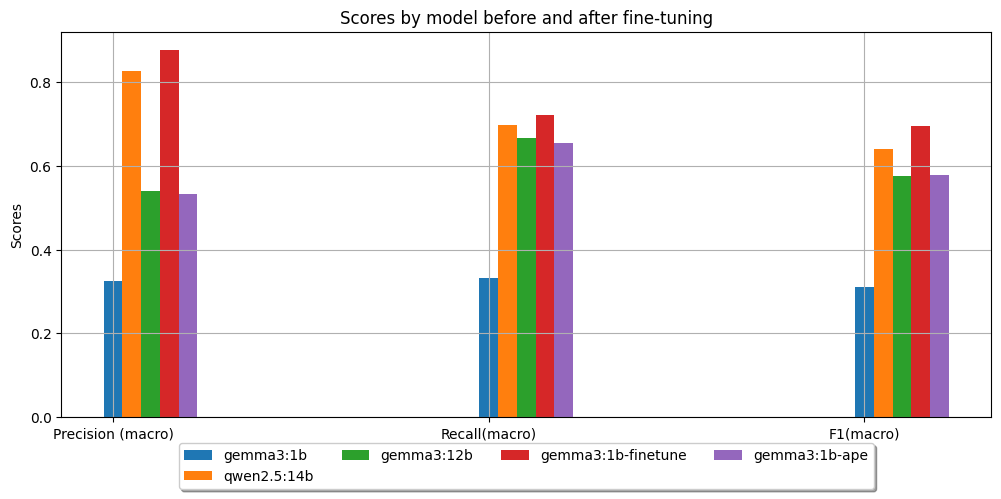

In [169]:
plot_metrics(
    metrics_baseline | ape_metrics,
    ["Precision (macro)", "Recall(macro)", "F1(macro)"],
    "Scores by model before and after fine-tuning",
)

In [87]:
from ollama import chat
from ollama import ChatResponse

# model="ollama/gemma3:4b-it-bf16_ft"
model = "gemma3:4b"
response: ChatResponse = chat(
    model=model,
    messages=[
        {
            "role": "system",
            "content": """Your input fields are:
            1. `sms_text` (str)

            Your output fields are:
            1. `category` (Literal['ham', 'spam', 'smishing'])

            All interactions will be structured in the following way, with the appropriate values filled in.

            Inputs will have the following structure:

                [[ ## sms_text ## ]]
                    {sms_text}

                    Outputs will be a JSON object with the following fields.

            {
            "category": "{category}        # note: the value you produce must be one of: ham; spam; smishing"
            }

            In adhering to this structure, your objective is:
            Given an SMS text, predict whether it is ham, spam, or smishing.
            Output only the predicted label.
""",
        },
        {
            "role": "user",
            "content": """
        [[ ## sms_text ## ]]
TFree entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question

Respond with a JSON object in the following order of fields: `category` (must be formatted as a valid Python Literal['ham', 'spam', 'smishing']).
        """,
        },
    ],
)
print(response["message"]["content"])
# or access fields directly from the response object
print(response.message.content)

```json
{
    "category": "smishing"
}
```
```json
{
    "category": "smishing"
}
```
